In [31]:
# ---
# # Week 2: Baseline Model Development
# 
# **Goal:** Build simple baseline models to compare with later transformer models.
# 
# Models:
# - Majority Classifier
# - TF-IDF + Logistic Regression
# 
# Deliverables:
# - Saved model: models/tfidf_logreg.pkl
# - Saved metrics: artifacts/baseline_metrics.json
# ---

import pandas as pd
import numpy as np
import os
import json
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [32]:
# Load the cleaned data 
df = pd.read_csv("../data/file-for-fineTuning.csv")

print("Dataset shape:", df.shape)
df.head()

Dataset shape: (495, 5)


,text,label,ticket_id,agent_name,text_length
0,Where can I find API rate limits documentation?,other,1000,Dana,47
1,Can I migrate data from Freshdesk?,other,1001,Bob,34
2,Cannot update billing address; page keeps relo...,billing,1002,Charlie,52
3,Looking for a product roadmap or upcoming feat...,other,1003,Dana,51
4,Dark mode toggled but UI stays light.,tech_support,1004,Alice,37


### Define Columns and Split the Data

In [33]:
# Identifying text and label columns
text_col = "text"   
label_col = "label"     
X = df[text_col]
y = df[label_col]

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Baseline Model 1 — Majority Classifier

In [34]:
# Find the majority class
majority_class = y_train.mode()[0]
print("Majority class:", majority_class)

# Predict majority class for all test samples
y_pred_majority = [majority_class] * len(y_test)

# Evaluate
majority_acc = accuracy_score(y_test, y_pred_majority)
majority_f1 = f1_score(y_test, y_pred_majority, average="weighted")

print("Majority Classifier Accuracy:", majority_acc)
print("Majority Classifier F1:", majority_f1)

Majority class: other
Majority Classifier Accuracy: 0.3333333333333333
Majority Classifier F1: 0.16666666666666666


### Baseline Model 2 — TF-IDF + Logistic Regression

In [35]:
# Vectorize text data
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train Logistic Regression model
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_tfidf, y_train)

# Predictions
y_pred_logreg = log_reg.predict(X_test_tfidf)

# Evaluate
logreg_acc = accuracy_score(y_test, y_pred_logreg)
logreg_f1 = f1_score(y_test, y_pred_logreg, average="weighted")

print("TF-IDF + Logistic Regression Accuracy:", logreg_acc)
print("TF-IDF + Logistic Regression F1:", logreg_f1)

TF-IDF + Logistic Regression Accuracy: 0.9393939393939394
TF-IDF + Logistic Regression F1: 0.9386916786916787


# Confusion Matrix & Classification Report

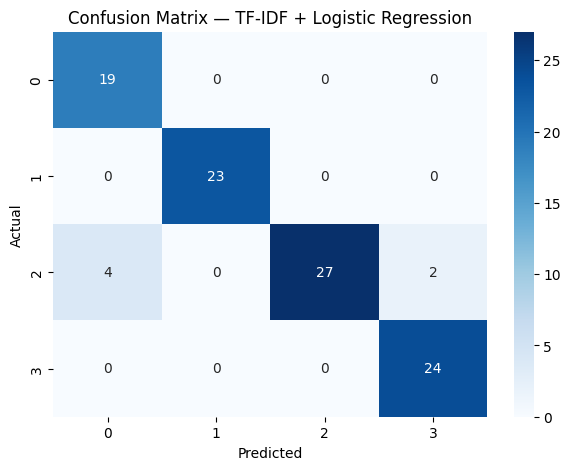

Classification Report:

              precision    recall  f1-score   support

     account       0.83      1.00      0.90        19
     billing       1.00      1.00      1.00        23
       other       1.00      0.82      0.90        33
tech_support       0.92      1.00      0.96        24

    accuracy                           0.94        99
   macro avg       0.94      0.95      0.94        99
weighted avg       0.95      0.94      0.94        99



In [36]:
plt.figure(figsize=(7,5))
sns.heatmap(confusion_matrix(y_test, y_pred_logreg), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix — TF-IDF + Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("Classification Report:\n")
print(classification_report(y_test, y_pred_logreg))

In [37]:
# Analyze what the model learned
print(" MODEL ANALYSIS:")
print(f"Number of features: {len(vectorizer.get_feature_names_out())}")
print(f"Model coefficients shape: {log_reg.coef_.shape}")

# Check most important features for each class
print("\nTOP PREDICTIVE WORDS PER CATEGORY:")
feature_names = vectorizer.get_feature_names_out()

for i, class_name in enumerate(log_reg.classes_):
    # Get top 5 features for this class
    top_indices = np.argsort(log_reg.coef_[i])[-5:][::-1]
    top_features = [feature_names[idx] for idx in top_indices]
    print(f"{class_name}: {', '.join(top_features)}")

 MODEL ANALYSIS:
Number of features: 548
Model coefficients shape: (4, 548)

TOP PREDICTIVE WORDS PER CATEGORY:
account: to, need, and, account, need to
billing: charged, order, incorrectly, days, refund not
other: can, data, or, for, please
tech_support: on, file, with, website returns, website


In [38]:
# Understand data better
print("\nDATA CHARACTERISTICS:")
print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"Vocabulary size: {X_train_tfidf.shape[1]}")

# Check text length
print(f"\nTEXT LENGTH STATS:")
print(f"Average characters: {X_train.str.len().mean():.1f}")
print(f"Min characters: {X_train.str.len().min()}")
print(f"Max characters: {X_train.str.len().max()}")

# Check class distribution
print(f"\nCLASS DISTRIBUTION:")
print(y_train.value_counts())


DATA CHARACTERISTICS:
Training samples: 396
Test samples: 99
Vocabulary size: 548

TEXT LENGTH STATS:
Average characters: 44.0
Min characters: 30
Max characters: 58

CLASS DISTRIBUTION:
label
other           133
tech_support     95
billing          90
account          78
Name: count, dtype: int64


#### Save Model and Metrics

In [39]:
# Create directories if they don’t exist
os.makedirs("models", exist_ok=True)
os.makedirs("artifacts", exist_ok=True)

# Save the TF-IDF + Logistic Regression model
joblib.dump({"vectorizer": vectorizer, "model": log_reg}, "models/tfidf_logreg.pkl")

# Save metrics
baseline_metrics = {
    "majority_classifier": {
        "accuracy": majority_acc,
        "weighted_f1": majority_f1
    },
    "tfidf_logistic_regression": {
        "accuracy": logreg_acc,
        "weighted_f1": logreg_f1
    }
}

with open("artifacts/baseline_metrics.json", "w") as f:
    json.dump(baseline_metrics, f, indent=4)

print("Saved model to models/tfidf_logreg.pkl")
print("Saved metrics to artifacts/baseline_metrics.json")

Saved model to models/tfidf_logreg.pkl
Saved metrics to artifacts/baseline_metrics.json


### Compare Baselines (Visual Summary)

C:\Users\HUMAIDU\AppData\Local\Temp\ipykernel_26620\1264238178.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="Accuracy", data=metrics_df, palette="viridis")


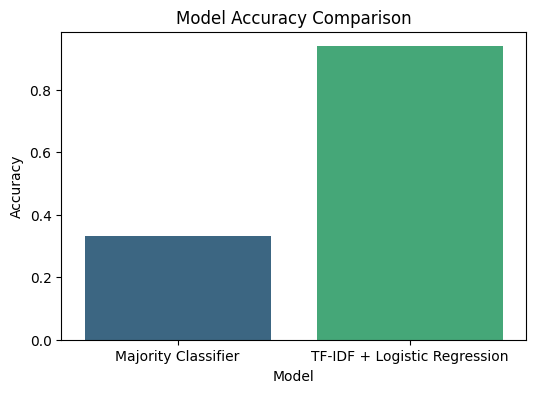

,Model,Accuracy,F1
0,Majority Classifier,0.333333,0.166667
1,TF-IDF + Logistic Regression,0.939394,0.938692


In [40]:
# Create comparison DataFrame
metrics_df = pd.DataFrame([
    {"Model": "Majority Classifier", "Accuracy": majority_acc, "F1": majority_f1},
    {"Model": "TF-IDF + Logistic Regression", "Accuracy": logreg_acc, "F1": logreg_f1}
])

# Plot
plt.figure(figsize=(6,4))
sns.barplot(x="Model", y="Accuracy", data=metrics_df, palette="viridis")
plt.title("Model Accuracy Comparison")
plt.show()

metrics_df

Notebook Summary
Summary of Week 2:

Implemented Majority Classifier and TF-IDF + Logistic Regression

Evaluated both models on test data

Visualized performance and confusion matrix

Saved model to models/tfidf_logreg.pkl

Saved metrics to artifacts/baseline_metrics.json

Next step: Proceed to Week 3 — Transformer Model Fine-Tuning, where we’ll:

Load and fine-tune distilbert-base-uncased

Evaluate and compare it with baseline models